# Preparation

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random
from geopy.distance import geodesic

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [2]:
# Import all datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train_station = pd.read_csv('/content/sg-train-stations.csv')
hawker = pd.read_csv('/content/sg-gov-markets-hawker-centres.csv')
sp_mall = pd.read_csv('/content/sg-shopping-malls.csv')
demographics = pd.read_csv('/content/sg-population-demographics.csv')
primary_school = pd.read_csv('/content/sg-primary-schools.csv')
secondary_school = pd.read_csv('/content/sg-secondary-schools.csv')
commercial_centre = pd.read_csv('/content/sg-commerical-centres.csv')

In [ ]:
# Have a look of the datasets
print('\n The training data has {} records and {} features \n'.format(train.shape[0], train.shape[1]))
train.head()


 The training data has 431732 records and 17 features 



,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0


In [ ]:
# Test data
print('\n The test data has {} records and {} features \n'.format(test.shape[0], test.shape[1]))
test.head()


 The test data has 107934 records and 16 features 



,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region
0,2004-01,bukit batok,4 room,186,bukit batok west avenue 6,04 to 06,94.0,new generation,uncategorized,1989,1.346581,103.744085,0.0,bukit batok west,bukit batok,west region
1,2001-11,tampines,5 room,366,tampines street 34,04 to 06,122.0,improved,uncategorized,1997,1.357618,103.961379,0.0,tampines east,tampines,east region
2,2002-07,jurong east,3 room,206,jurong east street 21,01 to 03,67.0,new generation,uncategorized,1982,1.337804,103.741998,0.0,toh guan,jurong east,west region
3,2015-04,ang mo kio,3 room,180,Ang Mo Kio Avenue 5,04 to 06,82.0,new generation,uncategorized,1981,1.380084,103.849574,0.0,yio chu kang east,ang mo kio,north-east region
4,2004-04,clementi,5 room,356,clementi avenue 2,01 to 03,117.0,standard,uncategorized,1978,1.313960,103.769831,0.0,clementi north,clementi,west region


# ***Feature Engineering***

We have recognized that the distribution of **'resale_price'** is right skewed. 

*However, most ML models, especially regression models, do not like non-normally distributed data.*

To handle that, we apply **log(1+x) tranform** to fix skew. 




In [3]:
train['resale_price'] = np.log1p(train["resale_price"])

Let's plot the distribution again


 mean = 12.53 and variance = 0.43



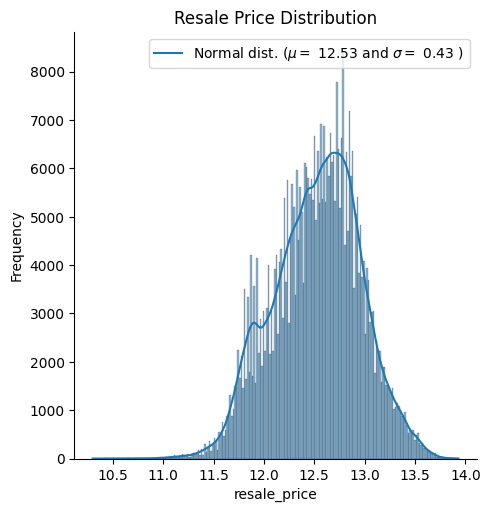


 Skewness: -0.1867011548358452,  Kurtosis: -0.21147737112136067 



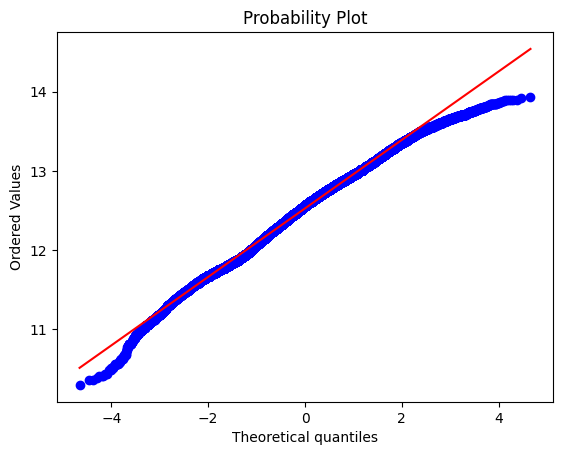

In [ ]:
sns.displot(train['resale_price'], kde=True);

# Get the distribution parameters
(mean, variance) = norm.fit(train['resale_price'])
print( '\n mean = {:.2f} and variance = {:.2f}\n'.format(mean, variance))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, variance)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Resale Price Distribution')
plt.show()

# And the probability plot 
print('\n Skewness: {},  Kurtosis: {} \n'.format(train['resale_price'].skew(), train['resale_price'].kurt()))
fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

*Much better now!*


---

*Let's do some more preparation before further processing*

In [4]:
# Split features and labels
target_variable = train['resale_price'].reset_index(drop=True)
train = train.drop(['resale_price'], axis=1)

# Combine traning and testing data for feature transformation
df = pd.concat([train, test]).reset_index(drop=True)
print('The combined dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The combined dataset has 539666 rows and 16 columns


In [5]:
# Save a copy
df.to_csv('data_combined.csv', index=False)

### Drop redundant features

*removing redundant/unimportant features can help us reduce data dimensionality*

In [7]:
# 'elevation' and 'eco_category' are redundant features as they both have only one unique value
redundant_features = []

for col in df.columns:
  unique = df[col].nunique()
  print('{}: has {} unique values'.format(col, unique))
  print('----------------------------------')
  if unique == 1: 
    redundant_features.append(col)

month: has 251 unique values
----------------------------------
town: has 26 unique values
----------------------------------
flat_type: has 12 unique values
----------------------------------
block: has 2475 unique values
----------------------------------
street_name: has 1103 unique values
----------------------------------
storey_range: has 25 unique values
----------------------------------
floor_area_sqm: has 189 unique values
----------------------------------
flat_model: has 20 unique values
----------------------------------
eco_category: has 1 unique values
----------------------------------
lease_commence_date: has 54 unique values
----------------------------------
latitude: has 9145 unique values
----------------------------------
longitude: has 9145 unique values
----------------------------------
elevation: has 1 unique values
----------------------------------
subzone: has 155 unique values
----------------------------------
planning_area: has 32 unique values
---------

In [8]:
# 'block' is considered to be redundant since block numbers of Singapore HDB flat do not bear useful information
redundant_features += ['block', 'street_name']

In [9]:
# drop the redundant features
print('Before dropping redundant features, the dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
df = df.drop(redundant_features, axis=1)
print('After dropping redundant features, the dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

Before dropping redundant features, the dataset has 539666 rows and 16 columns
After dropping redundant features, the dataset has 539666 rows and 12 columns


In [10]:
# Save a copy
df.to_csv('data_redundant_dropped.csv', index=False)

### Create new features

Now let's create some interesting features

In [11]:
population = pd.DataFrame(columns=['planning_area', 'subzone', '0-19', '20-39', '40-59', '60+'])
age_list = [['0-4', '5-9', '10-14', '15-19'], ['20-24', '25-29', '30-34', '35-39'],
            ['40-44', '45-49', '50-54', '55-59'], ['60-64', '65-69', '70-74',
                                                    '75-79', '80-84', '85+']]
df.planning_area = df.planning_area.str.lower()
df.planning_area = df.planning_area.str.replace(' ', '')
demographics.plannin_area = demographics.plannin_area.str.lower()
demographics.plannin_area = demographics.plannin_area.str.replace(' ', '')

df.subzone = df.subzone.str.lower()
df.subzone = df.subzone.str.replace(' ', '')
demographics.subzone = demographics.subzone.str.lower()
demographics.subzone = demographics.subzone.str.replace(' ', '')

area_list = list(demographics.groupby(['plannin_area', 'subzone']).groups.keys())
for p, s in area_list:
    temp = demographics[(demographics.plannin_area == p) & (demographics.subzone == s)]
    temp_res = [p, s]
    for age in age_list:
        temp_res.append(temp[temp.age_group.isin(age)]['count'].sum())
    population.loc[len(population.index)] = temp_res
    
df = pd.merge(df, population, how='left', on=['planning_area', 'subzone'])


In [ ]:

def binary_feature_generator(flats, infrastructure, distance):
  res = []
  for flat_location in flats:
    cnt = 0
    for infra_location in infrastructure:
      # The distance is calculated using geopy.distance.geodesic
      if geodesic(flat_location, infra_location).km <= distance:
        cnt+=1
    res.append(cnt)
  return res

In [ ]:
flats_loc = df[['latitude', 'longitude']].to_numpy()
# MRT
train_station_bin = binary_feature_generator(flats_loc, train_station[['lat', 'lng']].to_numpy(), 0.5)

# Shopping Mall
sp_mall_bin = binary_feature_generator(flats_loc, sp_mall[['lat', 'lng']].to_numpy(), 0.5)

# Primary school
secondary_school_bin = binary_feature_generator(flats_loc, secondary_school[['lat', 'lng']].to_numpy(), 0.5)

# Secondary school
primary_school_bin = binary_feature_generator(flats_loc, primary_school[['lat', 'lng']].to_numpy(), 0.5)

# Hawkers
hawker_bin = binary_feature_generator(flats_loc, hawker[['lat', 'lng']].to_numpy(), 0.5)

# Commercial Centre
commercial_centre_bin = binary_feature_generator(flats_loc, commercial_centre[['lat', 'lng']].to_numpy(), 0.5)

In [ ]:
generated_features = pd.DataFrame({
    'mrt': train_station_bin, 
    'sp_mall': sp_mall_bin, 'secondary_school': secondary_school_bin, 
    'primary_school': primary_school_bin, 'hawker': hawker_bin, 
    'commercial_centre': commercial_centre_bin
    })
print('The dataset has {} rows and {} columns'.format(generated_features.shape[0], generated_features.shape[1])) 
# save the dataset to csv
generated_features.to_csv('generated_features.csv', index=False)

The dataset has 539666 rows and 6 columns


In [14]:
df = pd.concat([df, generated_features], axis = 1).reset_index(drop=True)

In [16]:
# Create another feature named 'remaining_lease' denoting the remaining years of lease of the flat when it is sold
remaining_lease = 99 - df['month'].str[:4].apply(lambda x: int(x)) + df['lease_commence_date']
df['remaining_lease'] = remaining_lease

In [23]:
print('\nThe dataset now has {} features\n'.format(df.shape[1]))
df.head()


The dataset now has 23 features



,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,...,20-39,40-59,60+,mrt,sp_mall,secondary_school,primary_school,hawker,commercial_centre,remaining_lease
0,2001-08,pasir ris,4 room,01 to 03,118.0,model a,1989,1.369008,103.958697,pasirrisdrive,...,17070.0,20220.0,8200.0,0,0,0,0,0,0,87
1,2014-10,punggol,5-room,10 to 12,110.0,improved,2003,1.399007,103.906991,punggolfield,...,12410.0,13550.0,4990.0,1,0,1,0,0,0,88
2,2020-09,sengkang,5 room,01 to 03,112.0,premium apartment,2004,1.388348,103.873815,fernvale,...,13740.0,8090.0,3760.0,1,1,0,0,0,0,83
3,2000-10,clementi,3 room,07 to 09,67.0,new generation,1980,1.318493,103.766702,clementinorth,...,7650.0,8600.0,7820.0,1,1,0,0,0,0,79
4,2013-01,bukit batok,3-room,07 to 09,73.0,model a,1985,1.348149,103.742658,bukitbatokwest,...,4400.0,4900.0,2740.0,0,0,0,0,0,0,71


In [34]:
df['0-19'] = df['0-19'].fillna(df['0-19'].mean())
df['20-39'] = df['20-39'].fillna(df['20-39'].mean())
df['40-59'] = df['40-59'].fillna(df['40-59'].mean())
df['60+'] = df['60+'].fillna(df['60+'].mean())

In [35]:
df.isna().sum()

month                  0
town                   0
flat_type              0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
latitude               0
longitude              0
subzone                0
planning_area          0
region                 0
0-19                   0
20-39                  0
40-59                  0
60+                    0
mrt                    0
sp_mall                0
secondary_school       0
primary_school         0
hawker                 0
commercial_centre      0
remaining_lease        0
dtype: int64

### Check highly skewed features

*It is important to ensure that no numerical feature is highly skewed*

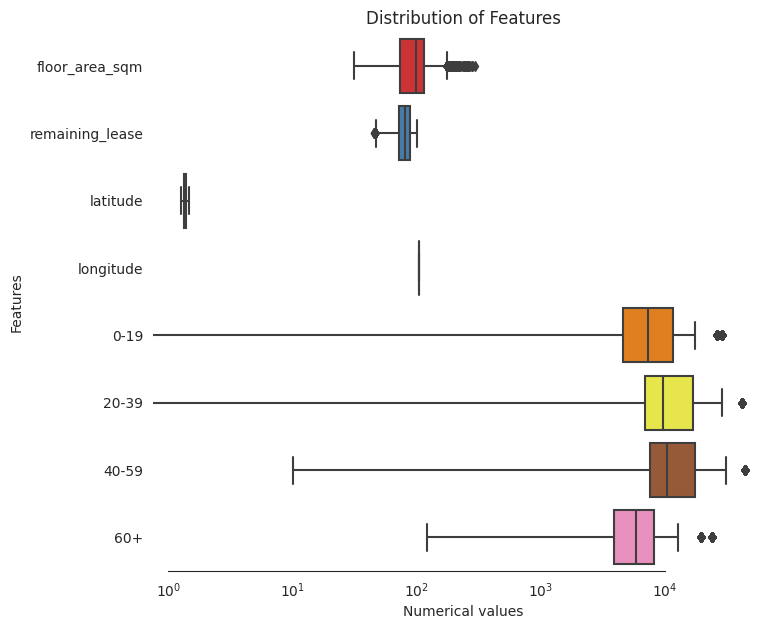

In [26]:
# List all numerical features
numerical_features = ['floor_area_sqm', 'remaining_lease', 'latitude', 'longitude', '0-19', '20-39', '40-59','60+']


# Boxplot to visualize the skewness of the numerical features
sns.set_style("white")

f, ax = plt.subplots(figsize=(8, 7))

ax.set_xscale("log")
ax = sns.boxplot(data=df[numerical_features] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Features")
ax.set(xlabel="Numerical values")
ax.set(title="Distribution of Features")

sns.despine(trim=True, left=True)

In [27]:
# Check skewness of all features
skewness = df[numerical_features].apply(lambda x: skew(x))

high_skewed = skewness[abs(skewness) > 0.5]

print("There are {} numerical features with skewness > 0.5 :\n".format(high_skewed.shape[0]))
high_skewed

There are 0 numerical features with skewness > 0.5 :



Series([], dtype: float64)

Great, we have no highly skewed numerical features in our dataset


*Note: We use the scipy function boxcox1p which computes the Box-Cox transformation to normalize skewed data.*

In [ ]:
# We don't need this anymore
# df[high_skewed.index] = boxcox1p(df[high_skewed.index], boxcox_normmax(df[high_skewed.index] + 1))

### Eliminate ambiguity in the dataset

Before eliminating ambiguity:  ['4 room' '5-room' '5 room' '3 room' '3-room' 'executive' '2 room'
 '4-room' 'multi generation' '2-room' '1-room' '1 room'] 

After eliminating ambiguity:  ['4-room' '5-room' '3-room' 'executive' '2-room' 'multi generation'
 '1-room'] 



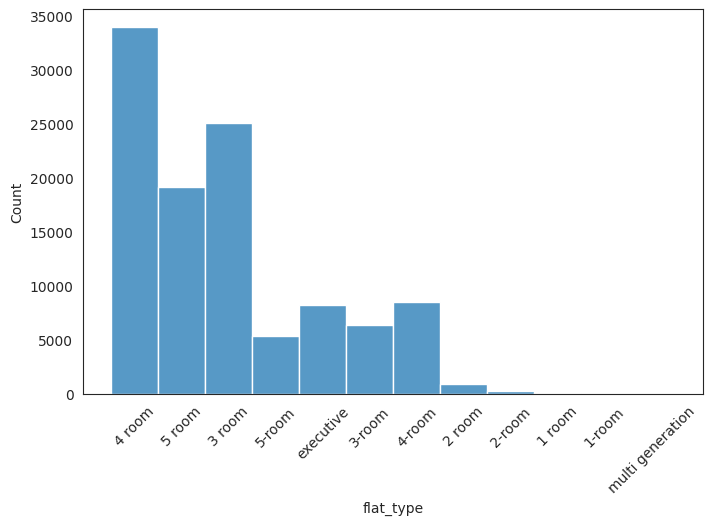

In [36]:
# Notice that 1-room and 1 room in 'flat_type' are really the same thing
print('Before eliminating ambiguity: ', df['flat_type'].unique(), '\n')
df['flat_type'].unique()
print("==========================================================")
# Fix the problem
df['flat_type'] = df['flat_type'].replace({'1 room': '1-room', '2 room': '2-room', '3 room': '3-room', '4 room': '4-room', '5 room': '5-room'})
print('After eliminating ambiguity: ', df['flat_type'].unique(), '\n')

# Plot the distribution again

fig = plt.figure(figsize=(8, 5))
sns.histplot(test['flat_type'])
plt.xticks(rotation=45)
plt.show()

In [37]:
df = df[df['floor_area_sqm'] > 0]

### Encoding categorical features

In [39]:
# First check data types
df.dtypes

month                   object
town                    object
flat_type               object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
latitude               float64
longitude              float64
subzone                 object
planning_area           object
region                  object
0-19                   float64
20-39                  float64
40-59                  float64
60+                    float64
mrt                      int64
sp_mall                  int64
secondary_school         int64
primary_school           int64
hawker                   int64
commercial_centre        int64
remaining_lease          int64
dtype: object

In [40]:
# As we mentioned before, 'lease_commence_date' should be treated as categorical feature
df['lease_commence_date'] = df['lease_commence_date'].apply(str)

In [41]:
# Label Encoding categorical features that contain information in their ordering set or have too many distinct values
label_features = []
for col in df.columns:
  if df[col].dtype == 'object':
    if df[col].nunique() > 10: label_features.append(col)

print('There are {} features need to be label encoded: \n'.format(len(label_features)))
print(label_features)

There are 7 features need to be label encoded: 

['month', 'town', 'storey_range', 'flat_model', 'lease_commence_date', 'subzone', 'planning_area']


In [42]:
for feature in label_features:
    lbl = LabelEncoder() 
    lbl.fit(list(df[feature].values)) 
    df[feature] = lbl.transform(list(df[feature].values))

In [43]:
# One hot encoding the rest categorical features
df = pd.get_dummies(df)
print('The final dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
df.head()

The final dataset has 539666 rows and 33 columns


,month,town,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,...,flat_type_3-room,flat_type_4-room,flat_type_5-room,flat_type_executive,flat_type_multi generation,region_central region,region_east region,region_north region,region_north-east region,region_west region
0,19,16,0,118.0,7,23,1.369008,103.958697,94,19,...,0,1,0,0,0,0,1,0,0,0
1,177,17,5,110.0,4,37,1.399007,103.906991,100,20,...,0,0,1,0,0,0,0,0,1,0
2,248,20,0,112.0,12,38,1.388348,103.873815,46,24,...,0,0,1,0,0,0,0,0,1,0
3,9,9,4,67.0,11,14,1.318493,103.766702,34,9,...,1,0,0,0,0,0,0,0,0,1
4,156,3,4,73.0,7,19,1.348149,103.742658,22,3,...,1,0,0,0,0,0,0,0,0,1


In [44]:
df.dtypes

month                           int64
town                            int64
storey_range                    int64
floor_area_sqm                float64
flat_model                      int64
lease_commence_date             int64
latitude                      float64
longitude                     float64
subzone                         int64
planning_area                   int64
0-19                          float64
20-39                         float64
40-59                         float64
60+                           float64
mrt                             int64
sp_mall                         int64
secondary_school                int64
primary_school                  int64
hawker                          int64
commercial_centre               int64
remaining_lease                 int64
flat_type_1-room                uint8
flat_type_2-room                uint8
flat_type_3-room                uint8
flat_type_4-room                uint8
flat_type_5-room                uint8
flat_type_ex

In [ ]:
# Save a copy
df.to_csv('data_combined_processed.csv', index=False)

### Split the combined dataset back to training and testing sets

In [45]:
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)

In [46]:
train = pd.concat([train, target_variable], axis = 1)

### Drop duplicated data

In [48]:
# Fetch all duplicate records in training set
duplicates = train[train.duplicated()]
print('There are {} duplicate records in the dataset'.format(duplicates.shape[0]))

There are 67 duplicate records in the dataset


In [49]:
# Drop duplicate records and reset index
train = train.drop_duplicates(ignore_index=True)
print('After dropping duplicate data, the training dataset now has {} rows'.format(train.shape[0]))

After dropping duplicate data, the training dataset now has 431665 rows


In [50]:
# save the processed dataset
train.to_csv('train_processed.csv', index=False)
test.to_csv('test_processed.csv', index=False)